In [1]:
import sys
from pathlib import Path

In [2]:
# !{sys.executable} -m pip install -qe ..

In [3]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

## imports

In [89]:
from chequeparser.wrappers.detection_results import DetectionResults
from chequeparser.wrappers.bbox import BBox
from chequeparser.utilities.ds_utils import concat_ds

In [5]:
from chequeparser.datasets.fileds import FileDS
from chequeparser.datasets.imageds import ImageDS

/home/ajkdrag/workspace/chequeparser/src/chequeparser/utilities/io_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [189]:
from chequeparser.models.arch import UL_RTDETR, DOCTR_RECOG_PRETRAINED, DOCTR_DETECT_PRETRAINED
from chequeparser.models.detection.ultralytics import UltralyticsDetect
from chequeparser.models.detection.doctr import DoctrDetect
from chequeparser.models.recognition.doctr import DoctrRecognize
from chequeparser.core.detector import detect
from chequeparser.core.recognizer import recognize

In [190]:
from chequeparser.utilities.misc import partition_list

## config

In [191]:
dir_images = "../data/public/train/images/"

## test pkg

In [192]:
file_ds = FileDS(dir_images)

  0%|          | 0/369 [00:00<?, ?it/s]

2024-02-14 16:01:59.784 | INFO     | chequeparser.utilities.io_utils:get_image_files:31 - Found 369 image files.


In [193]:
model = UltralyticsDetect("../pretrained/best.pt", arch=UL_RTDETR)

In [194]:
doctr_det_arch_config = {
    "preserve_aspect_ratio": True,
    "symmetric_pad": True
}
det_model_doctr = DoctrDetect(path="db_resnet50", arch=DOCTR_DETECT_PRETRAINED, arch_config = doctr_det_arch_config)

In [195]:
len(file_ds)

369

In [196]:
sample_ds = file_ds.sample(k=5, batched=True)

In [197]:
sample_ds.names

['X_085_jpeg_jpg.rf.37ea8d9ebfbb2ff715c21148b130d528.jpg',
 'X_074_jpeg_jpg.rf.308a150ac161e9e3a1226ce9e8c9d561.jpg',
 '191_jpg.rf.450ef48720a27fb3def778403bf7351b.jpg',
 '0A3EF7A600C4423A9C0BD112C5D259A8_FACE_jpg.rf.2f080a3c9fec88f937b86870ffbc2674.jpg',
 '8_jpg.rf.93105de5abc572b70639fe0515009e4a.jpg']

5


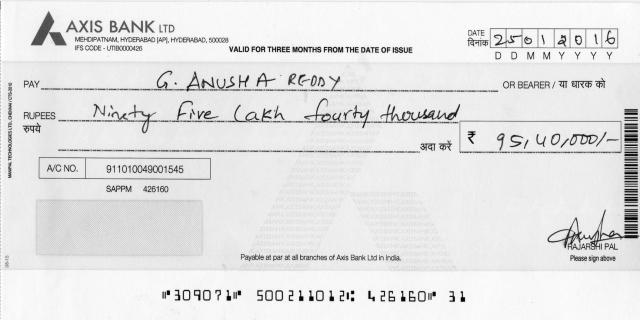

In [198]:
print(len(sample_ds))
sample_ds[0]

In [199]:
results = detect(model, sample_ds, stream=False)

2024-02-14 16:02:00.953 | INFO     | chequeparser.core.detector:detect:35 - Stream mode: False
2024-02-14 16:02:00.954 | INFO     | chequeparser.core.detector:detect:36 - Batched mode: True
2024-02-14 16:02:00.954 | INFO     | chequeparser.core.detector:detect:37 - Running predict on 5 samples



0: 640x640 1 amnt, 1 date, 1 micr, 1 orderof, 1 payee, 1: 640x640 1 amnt, 1 date, 1 micr, 1 orderof, 1 payee, 2: 640x640 1 amnt, 1 chk_no, 1 date, 1 micr, 1 orderof, 1 payee, 3: 640x640 1 amnt, 1 chk_no, 1 date, 1 micr, 1 orderof, 1 payee, 4: 640x640 1 amnt, 1 chk_no, 1 date, 1 micr, 1 orderof, 1 payee, 90.5ms
Speed: 1.2ms preprocess, 18.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


In [200]:
results_doctr = detect(det_model_doctr, sample_ds, stream=False)

2024-02-14 16:02:02.842 | INFO     | chequeparser.core.detector:detect:35 - Stream mode: False
2024-02-14 16:02:02.843 | INFO     | chequeparser.core.detector:detect:36 - Batched mode: True
2024-02-14 16:02:02.844 | INFO     | chequeparser.core.detector:detect:37 - Running predict on 5 samples


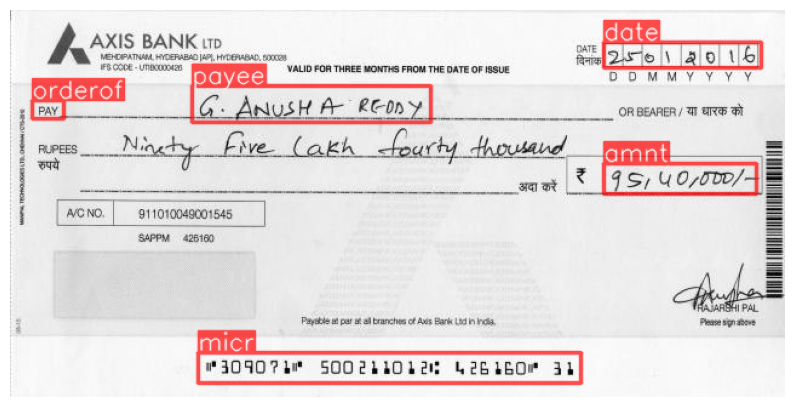

In [202]:
_ = results[0].draw(display=True, show_conf=False, show_label=True)

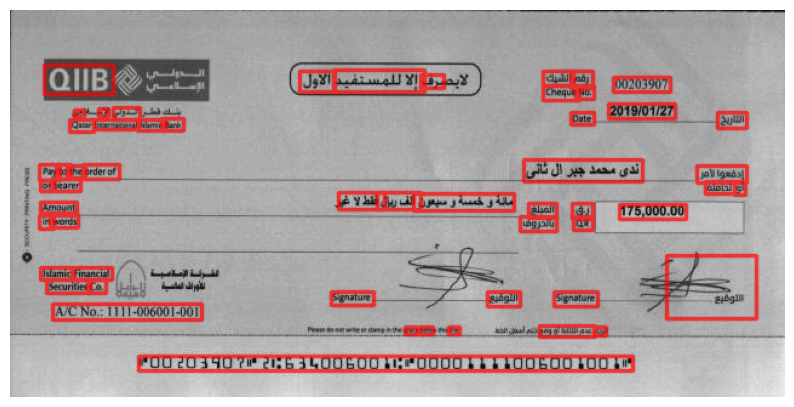

In [203]:
_ = results_doctr[3].draw(display=True, show_conf=False, show_label=False)

In [204]:
l_filter_by_cls = [result.filter_by_labels(["payee"]) for result in results]

### test filter by bbox

In [205]:
l_filter_by_cls

[[<chequeparser.wrappers.detection_results.DetectionResults at 0x7fadd60a5a90>],

In [240]:
l_boxes_inside_payee = [doctr_res.filter_by_bbox(res[0].bboxes[0], thresh=0.7) if len(res) > 0
                        else doctr_res.empty()
                        for doctr_res, res in zip(results_doctr, l_filter_by_cls)
                       ]

In [241]:
_ = [x.sort_bboxes_lr_() for x in l_boxes_inside_payee]

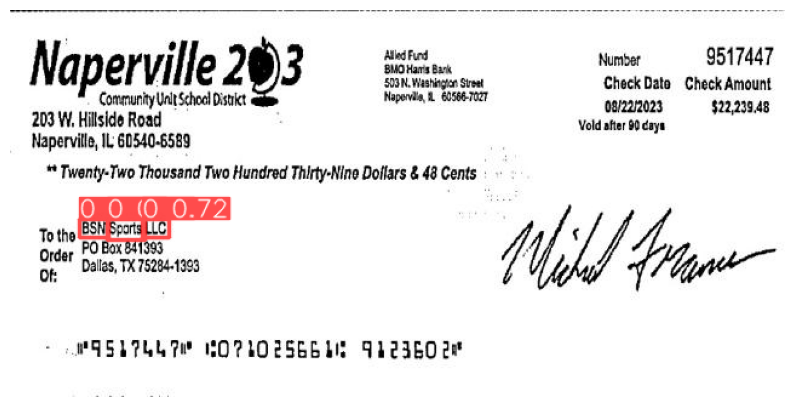

In [242]:
_ = l_boxes_inside_payee[4].draw(display=True)

In [243]:
payee_ds = concat_ds([result.create_ds() for result in l_boxes_inside_payee])

In [244]:
payee_ds.names

['0__X_085_jpeg_jpg.rf.37ea8d9ebfbb2ff715c21148b130d528.jpg',
 '0__X_085_jpeg_jpg.rf.37ea8d9ebfbb2ff715c21148b130d528.jpg',
 '0__X_085_jpeg_jpg.rf.37ea8d9ebfbb2ff715c21148b130d528.jpg',
 '0__X_074_jpeg_jpg.rf.308a150ac161e9e3a1226ce9e8c9d561.jpg',
 '0__X_074_jpeg_jpg.rf.308a150ac161e9e3a1226ce9e8c9d561.jpg',
 '0__191_jpg.rf.450ef48720a27fb3def778403bf7351b.jpg',
 '0__191_jpg.rf.450ef48720a27fb3def778403bf7351b.jpg',
 '0__191_jpg.rf.450ef48720a27fb3def778403bf7351b.jpg',
 '0__191_jpg.rf.450ef48720a27fb3def778403bf7351b.jpg',
 '0__0A3EF7A600C4423A9C0BD112C5D259A8_FACE_jpg.rf.2f080a3c9fec88f937b86870ffbc2674.jpg',
 '0__8_jpg.rf.93105de5abc572b70639fe0515009e4a.jpg',
 '0__8_jpg.rf.93105de5abc572b70639fe0515009e4a.jpg',
 '0__8_jpg.rf.93105de5abc572b70639fe0515009e4a.jpg']

### ocr

In [245]:
ocr_model = DoctrRecognize(arch=DOCTR_RECOG_PRETRAINED, path="crnn_vgg16_bn")

In [246]:
ocr_results = recognize(ocr_model, payee_ds, stream=False)

2024-02-14 16:15:46.920 | INFO     | chequeparser.core.recognizer:recognize:30 - Stream mode: False
2024-02-14 16:15:46.921 | INFO     | chequeparser.core.recognizer:recognize:31 - Batched mode: False
2024-02-14 16:15:46.922 | INFO     | chequeparser.core.recognizer:recognize:32 - Running predict on 13 samples


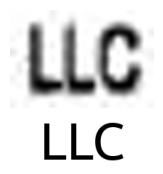

In [247]:
_ = ocr_results[12].draw(display=True)

In [248]:
len(ocr_results)

13

In [249]:
sizes = [len(r) for r in l_boxes_inside_payee]

In [250]:
part_ocr_results = partition_list(ocr_results, sizes)

In [251]:
for fname, l_res in zip(sample_ds.names, part_ocr_results):
    print(fname, " ".join([r.text for r in l_res]))

X_085_jpeg_jpg.rf.37ea8d9ebfbb2ff715c21148b130d528.jpg GANUSH A RGODY
X_074_jpeg_jpg.rf.308a150ac161e9e3a1226ce9e8c9d561.jpg KAwuha Chowdhasy
191_jpg.rf.450ef48720a27fb3def778403bf7351b.jpg PRIMARY PRODUCTS ING AMERICAS
0A3EF7A600C4423A9C0BD112C5D259A8_FACE_jpg.rf.2f080a3c9fec88f937b86870ffbc2674.jpg Jg
8_jpg.rf.93105de5abc572b70639fe0515009e4a.jpg BSN Sports LLC


In [254]:
max([3] + [1, 2])

3